<a href="https://colab.research.google.com/github/Pacharaponarp/Tuberculosis-Covid-19-Classification/blob/main/Covid_Admitted.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np 
import pandas as pd 
import os, warnings
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import gridspec
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from skimage import data, img_as_float
from skimage import exposure

def set_seed(seed=12345):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!mkdir '/content/data'
!cp -av '_' '/content/data'

In [4]:
drive.flush_and_unmount()

In [5]:
dataframe = pd.read_csv('/content/data/_.tsv', sep='\t', header=0)
img_path = '/content/data/_'
df = dataframe[['CXR File','Admitted']]
df.rename(columns = {'CXR File': 'filename', 'Admitted': 'label'}, inplace = True)
df['label'] = df['label'].astype(str)
df.head(10)

,filename,label
0,8/50778.png,0
1,7/43736.png,0
2,7/41166.png,0
3,8/52753.png,0
4,8/51542.png,0
5,7/48650.png,0
6,8/50833.png,0
7,7/46666.png,0
8,7/46664.png,0
9,7/47716.png,1


In [6]:
#train test split
print(df.shape)
df_train,df_val = train_test_split(df,test_size = 0.20, random_state = 1,stratify = df.label )
print("train not admitted:", df_train.loc[df_train.label == '0'].shape[0])
print("train admitted:", df_train.loc[df_train.label == '1'].shape[0])
print("val not admitted:", df_val.loc[df_val.label == '0'].shape[0])
print("val admitted:", df_val.loc[df_val.label == '1'].shape[0])


(631, 2)
train not admitted: 406
train admitted: 98
val not admitted: 102
val admitted: 25


In [ ]:
def hist_equal(img):
  return exposure.equalize_hist(img)*255

#imagedatagenerator
datagen = ImageDataGenerator(
    horizontal_flip = True,
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range= [0.9,1.0],
    #preprocessing_function = hist_equal
)
val_datagen = ImageDataGenerator(
    #preprocessing_function = hist_equal
)
train_gen = datagen.flow_from_dataframe(
    df_train,directory = img_path,
    x_col='filename', 
    y_col='label',
    target_size=(150, 150),
    batch_size = 32,
    class_mode = 'categorical'
)
val_gen = val_datagen.flow_from_dataframe(
    df_val,directory = img_path,
    x_col='filename', 
    y_col='label',
    target_size=(150, 150),
    batch_size = 32,
    class_mode = 'categorical'
)
ims,labels = train_gen.next()
titles = None
interp = False
# plot raw pixel data
print(ims[0].shape)
print(hist_equal(ims[0]).shape)
#print(ims[0])
if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
f = plt.figure(figsize=(20,10))
for i in range(20):
        sp = f.add_subplot(5, 4, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [8]:
pretrained_model = tf.keras.applications.ResNet101(
    input_shape=(150, 150, 3),
    include_top=False,
    weights='imagenet',
)
pretrained_model.trainable = False

model =keras.Sequential([
    layers.InputLayer(input_shape=(150, 150,3)),
    pretrained_model,
    layers.Flatten(),
    #layers.BatchNormalization(renorm=True),
    #layers.Dense(units = 32, activation = 'relu'),
    #layers.Dropout(rate=0.1),
    layers.Dense(units = 2,activation = 'softmax')
])
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0003)
model.compile(
    optimizer=optimizer,
    loss = 'binary_crossentropy',
    metrics=['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
)

model.summary()


171446536/171446536 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 5, 5, 2048)        42658176  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 2)                 102402    
                                                                 
Total params: 42,760,578
Trainable params: 102,402
Non-trainable params: 42,658,176
_________________________________________________________________


In [9]:
#early stopping,checkpoint,reduce_lr and scheduler

early_stopping = keras.callbacks.EarlyStopping(
    patience=15,
    min_delta=0,
    restore_best_weights=True,
)
filepath = '/content/data/'
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)
lrScheduler = keras.callbacks.LearningRateScheduler(scheduler)

In [10]:
history = model.fit_generator(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=[checkpoint,reduce_lr]
)

Epoch 1/30
16/16 [==============================] - ETA: 0s - loss: 1.3093 - accuracy: 0.7242 - precision: 0.7242 - recall: 0.7242
Epoch 1: val_accuracy improved from -inf to 0.84252, saving model to /content/data/


16/16 [==============================] - 68s 4s/step - loss: 1.3093 - accuracy: 0.7242 - precision: 0.7242 - recall: 0.7242 - val_loss: 0.7857 - val_accuracy: 0.8425 - val_precision: 0.8425 - val_recall: 0.8425 - lr: 3.0000e-04
Epoch 2/30
16/16 [==============================] - ETA: 0s - loss: 0.5606 - accuracy: 0.8710 - precision: 0.8710 - recall: 0.8710
Epoch 2: val_accuracy improved from 0.84252 to 0.87402, saving model to /content/data/


16/16 [==============================] - 52s 3s/step - loss: 0.5606 - accuracy: 0.8710 - precision: 0.8710 - recall: 0.8710 - val_loss: 0.3281 - val_accuracy: 0.8740 - val_precision: 0.8740 - val_recall: 0.8740 - lr: 3.0000e-04
Epoch 3/30
16/16 [==============================] - ETA: 0s - loss: 0.3275 - accuracy: 0.9107 - precision: 0.9107 - recall: 0.9107
Epoch 3: val_accuracy improved from 0.87402 to 0.91339, saving model to /content/data/


16/16 [==============================] - 52s 3s/step - loss: 0.3275 - accuracy: 0.9107 - precision: 0.9107 - recall: 0.9107 - val_loss: 0.3306 - val_accuracy: 0.9134 - val_precision: 0.9134 - val_recall: 0.9134 - lr: 3.0000e-04
Epoch 4/30
16/16 [==============================] - ETA: 0s - loss: 0.2350 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365
Epoch 4: val_accuracy did not improve from 0.91339
16/16 [==============================] - 12s 771ms/step - loss: 0.2350 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - val_loss: 0.3499 - val_accuracy: 0.8740 - val_precision: 0.8740 - val_recall: 0.8740 - lr: 3.0000e-04
Epoch 5/30
16/16 [==============================] - ETA: 0s - loss: 0.2036 - accuracy: 0.9405 - precision: 0.9405 - recall: 0.9405
Epoch 5: val_accuracy improved from 0.91339 to 0.92126, saving model to /content/data/


16/16 [==============================] - 53s 4s/step - loss: 0.2036 - accuracy: 0.9405 - precision: 0.9405 - recall: 0.9405 - val_loss: 0.3102 - val_accuracy: 0.9213 - val_precision: 0.9213 - val_recall: 0.9213 - lr: 3.0000e-04
Epoch 6/30
16/16 [==============================] - ETA: 0s - loss: 0.2325 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444
Epoch 6: val_accuracy did not improve from 0.92126
16/16 [==============================] - 13s 788ms/step - loss: 0.2325 - accuracy: 0.9444 - precision: 0.9444 - recall: 0.9444 - val_loss: 0.2984 - val_accuracy: 0.9213 - val_precision: 0.9213 - val_recall: 0.9213 - lr: 3.0000e-04
Epoch 7/30
16/16 [==============================] - ETA: 0s - loss: 0.1900 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365
Epoch 7: val_accuracy improved from 0.92126 to 0.92913, saving model to /content/data/


16/16 [==============================] - 54s 4s/step - loss: 0.1900 - accuracy: 0.9365 - precision: 0.9365 - recall: 0.9365 - val_loss: 0.3509 - val_accuracy: 0.9291 - val_precision: 0.9291 - val_recall: 0.9291 - lr: 3.0000e-04
Epoch 8/30
16/16 [==============================] - ETA: 0s - loss: 0.1891 - accuracy: 0.9524 - precision: 0.9524 - recall: 0.9524
Epoch 8: val_accuracy did not improve from 0.92913
16/16 [==============================] - 13s 792ms/step - loss: 0.1891 - accuracy: 0.9524 - precision: 0.9524 - recall: 0.9524 - val_loss: 0.3672 - val_accuracy: 0.8819 - val_precision: 0.8819 - val_recall: 0.8819 - lr: 3.0000e-04
Epoch 9/30
16/16 [==============================] - ETA: 0s - loss: 0.0998 - accuracy: 0.9623 - precision: 0.9623 - recall: 0.9623
Epoch 9: val_accuracy did not improve from 0.92913

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
16/16 [==============================] - 13s 791ms/step - loss: 0.0998 - accuracy: 0.9623 - precisio

best


accuracy        0.986111
val_accuracy    0.929134
dtype: float64

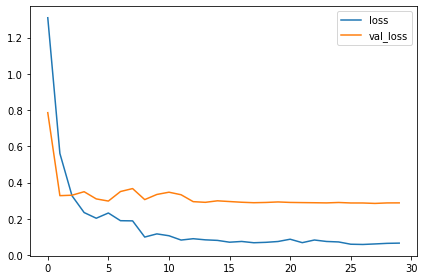

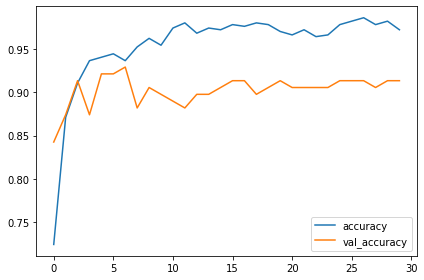

In [11]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

print('best')
history_frame.loc[:, ['accuracy', 'val_accuracy']].max()


In [12]:
results_val = model.evaluate_generator(val_gen, verbose=0)
print("    Val Loss: {:.5f}".format(results_val[0]))
print("Val Accuracy: {:.2f}%".format(results_val[1] * 100))
precision = results_val[2]
recall = results_val[3]
print("Val F1 score : {:.2f}".format(2*((precision*recall)/(precision+recall+1e-7))))

    Val Loss: 0.28831
Val Accuracy: 91.34%
Val F1 score : 0.91


In [13]:
from sklearn.metrics import confusion_matrix
Y_pred = model.predict_generator(val_gen, )
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(val_gen.classes, y_pred))


Confusion Matrix
[[82 20]
 [19  6]]


In [15]:
#this is for comparing with saved model
checkpoint_dir = os.path.dirname()
latest = tf.train.latest_checkpoint(checkpoint_dir)
model.load_weights(latest)

results_val_best = model.evaluate_generator(val_gen, verbose=0)
print("Best Val Loss: {:.5f}".format(results_val[0]))
print("Best Val Accuracy: {:.2f}%".format(results_val[1] * 100))
precision = results_val[2]
recall = results_val[3]
print("Best Val F1 score : {:.2f}".format(2*((precision*recall)/(precision+recall+1e-7))))


Best Val Loss: 0.28831
Best Val Accuracy: 91.34%
Best Val F1 score : 0.91
